# Controle e hiperparametros

In [ ]:
MAX_LEN = 160

BATCH_SIZE = 16

EPOCHS = 3

LR = 2e-5

# Imports e setup inicial

In [ ]:
# No Kaggle não é preciso, mas no Colab sim
!pip -q install transformers

In [ ]:
!pip install -q -U watermark

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy       : 1.22.4
pandas      : 1.5.3
torch       : 2.0.1+cu118
transformers: 4.30.1



In [ ]:
!nvidia-smi

Sat Jun 10 15:51:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Imports e setup
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
# Checagem da unidade de processamento
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("Conferindo a unidade de processamento:", device)

Conferindo a unidade de processamento: cuda:0


# Carregamento do dataset

In [ ]:
# Carrega o dataset
df = pd.read_csv("B2W-Reviews01.csv")

<ipython-input-8-67fdac0a2545>:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("B2W-Reviews01.csv")


In [ ]:
# Visualização inicial do dataset
display(df.shape)
display(df.head())

(132373, 14)

,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,NaN,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...,1958.0,F,RJ
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,NaN,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996.0,M,SC
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...,113022329,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984.0,M,SP
3,2018-01-01 00:35:54,ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863...,113851581,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,presente mais que desejado,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985.0,F,SP
4,2018-01-01 01:00:28,7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e...,131788803,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",lg,TV e Home Theater,TV,"Sem duvidas, excelente",5,Yes,"A entrega foi no prazo, as americanas estão de...",1994.0,M,MG


In [ ]:
# Cria uma nova coluna para manter os índices originais
df['original_index'] = df.index

In [ ]:
# As colunas "submission_date", "reviewer_id", "product_id", "review_title" e "reviewer_gender"
# não serão utilizadas, portanto serão removidas
df = df.drop(columns=['submission_date', 'reviewer_id', 'product_id', 'review_title', 'reviewer_gender'])

In [ ]:
# Verificação da ausência de valores
df.isnull().sum()

product_name                84
product_brand            91391
site_category_lv1            6
site_category_lv2         4013
overall_rating               0
recommend_to_a_friend       18
review_text               3275
reviewer_birth_year       5984
reviewer_state            3991
original_index               0
dtype: int64

In [ ]:
# Verifica-se a ausência de valores, portanto as linhas deverão ser removidas
df = df.dropna(subset=['review_text'])

# EDA

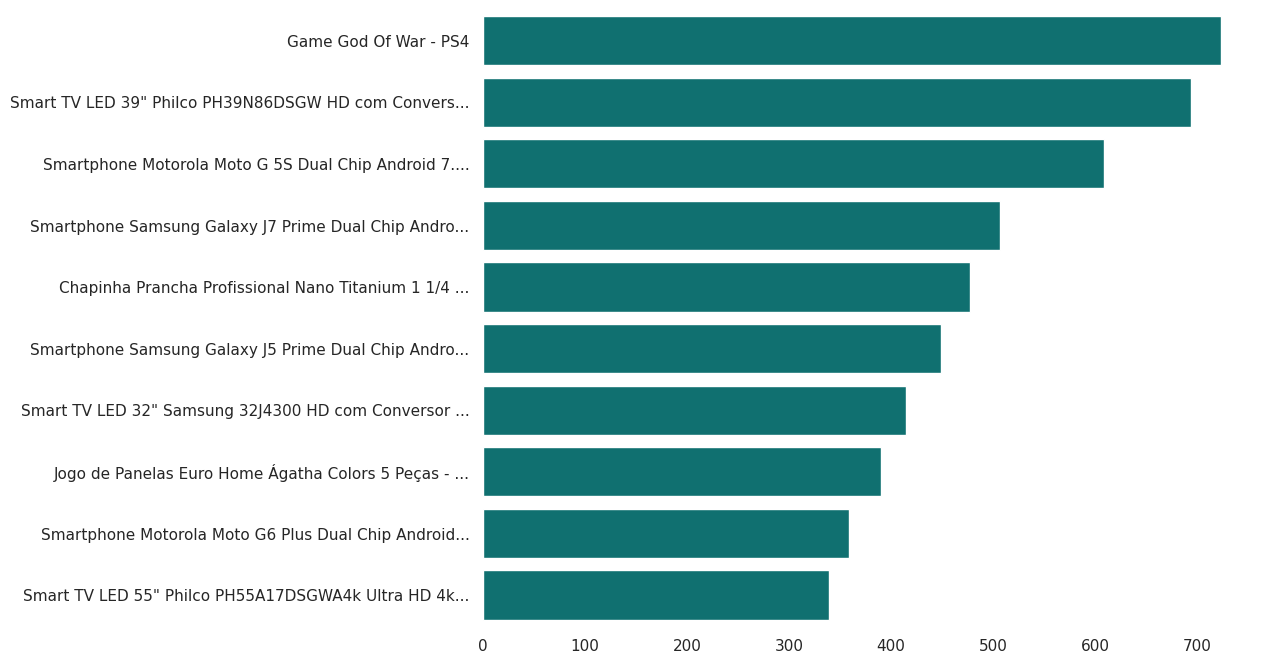

In [ ]:
# Plot dos produtos mais frequentes
# Contagem
product_count = df['product_name'].value_counts()

# Seleciona os mais frequentes
top_products = product_count.head(10)

# Limita o número de letras dos nomes dos produtos
top_products.index = [name[:50] + '...' if len(name) > 50 else name for name in top_products_neg.index]

# Cria o gráfico de barras horizontal
sns.set(style='white')
ax = sns.barplot(x=top_products, y=top_products.index, orient='h', color='#008080')
sns.despine(left=True, bottom=True)

# Define os rótulos dos eixos
#ax.set_title('Frequência dos produtos', fontsize=16)
ax = sns.barplot(x=top_products, y=top_products.index, orient='h', color='#008080')
ax.set(xlabel='', ylabel='')

# Define o tamanho da figura
sns.set(rc={'figure.figsize': (10, 8)})

# Mostra o gráfico
plt.show()

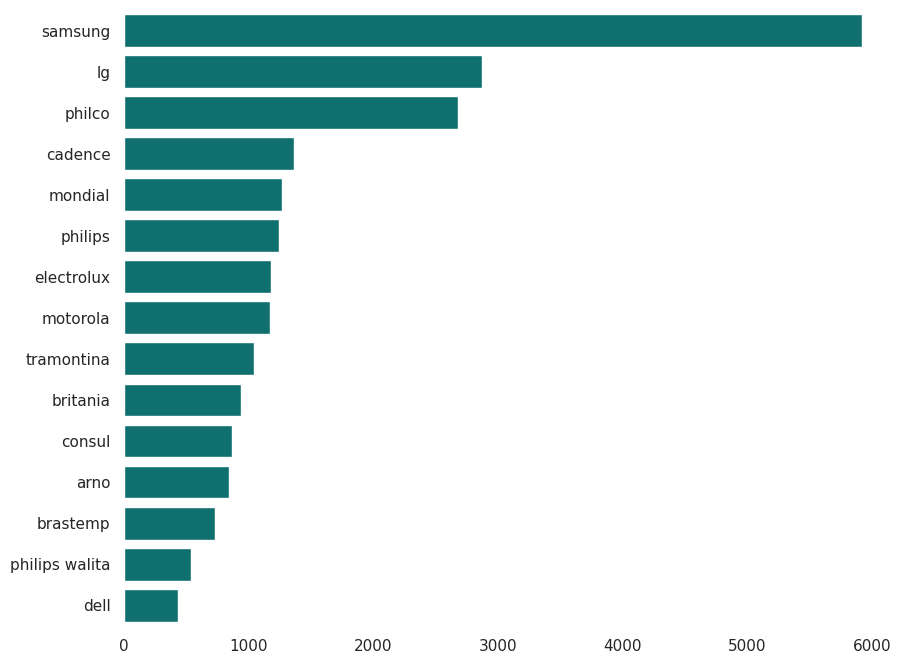

In [ ]:
# Plot das marcas mais frequentes
# Contagem
brand_count = df['product_brand'].value_counts()

# Seleciona os mais frequentes
top_brand = brand_count.head(15)

# Cria o gráfico de barras horizontal
sns.set(style='white')
ax = sns.barplot(x=top_brand, y=top_brand.index, orient='h', color='#008080')
sns.despine(left=True, bottom=True)

# Define os rótulos dos eixos
#ax.set_title('Frequência das marcas', fontsize=16)
ax = sns.barplot(x=top_brand, y=top_brand.index, orient='h', color='#008080')
ax.set(xlabel='', ylabel='')

# Define o tamanho da figura
sns.set(rc={'figure.figsize': (10, 8)})

# Mostra o gráfico
plt.show()

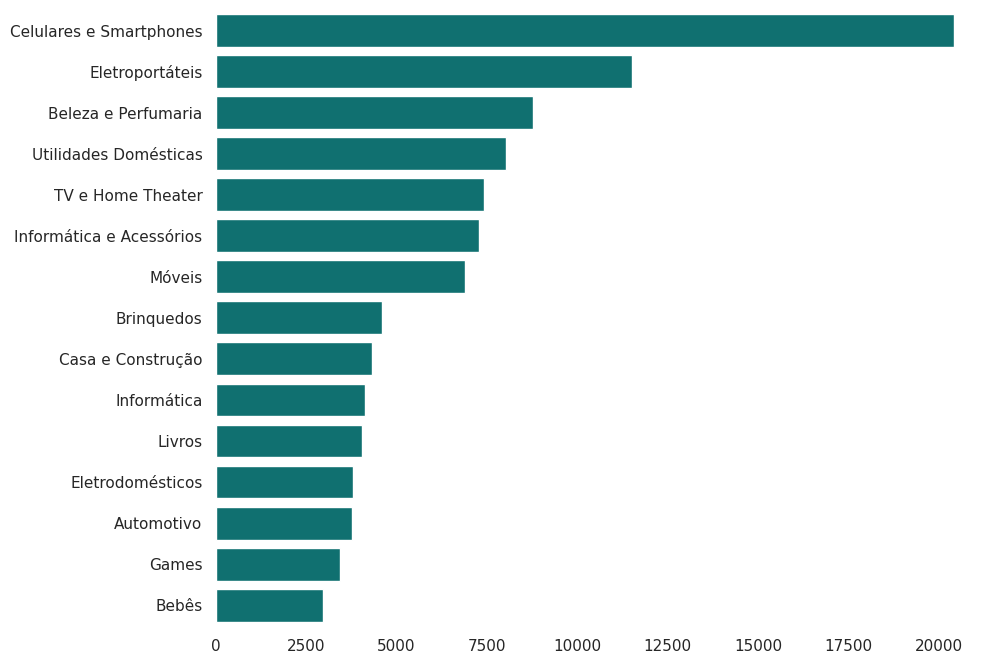

In [ ]:
# Plot das categorias mais frequentes
# Contagem
category_count = df['site_category_lv1'].value_counts()

# Seleciona os mais frequentes
top_category = category_count.head(15)

# Cria o gráfico de barras horizontal
sns.set(style='white')
ax = sns.barplot(x=top_category, y=top_category.index, orient='h', color='#008080')
sns.despine(left=True, bottom=True)

# Define os rótulos dos eixos
#ax.set_title('Frequência das categorias', fontsize=16)
ax = sns.barplot(x=top_category, y=top_category.index, orient='h', color='#008080')
ax.set(xlabel='', ylabel='')

# Define o tamanho da figura
sns.set(rc={'figure.figsize': (10, 8)})

# Mostra o gráfico
plt.show()

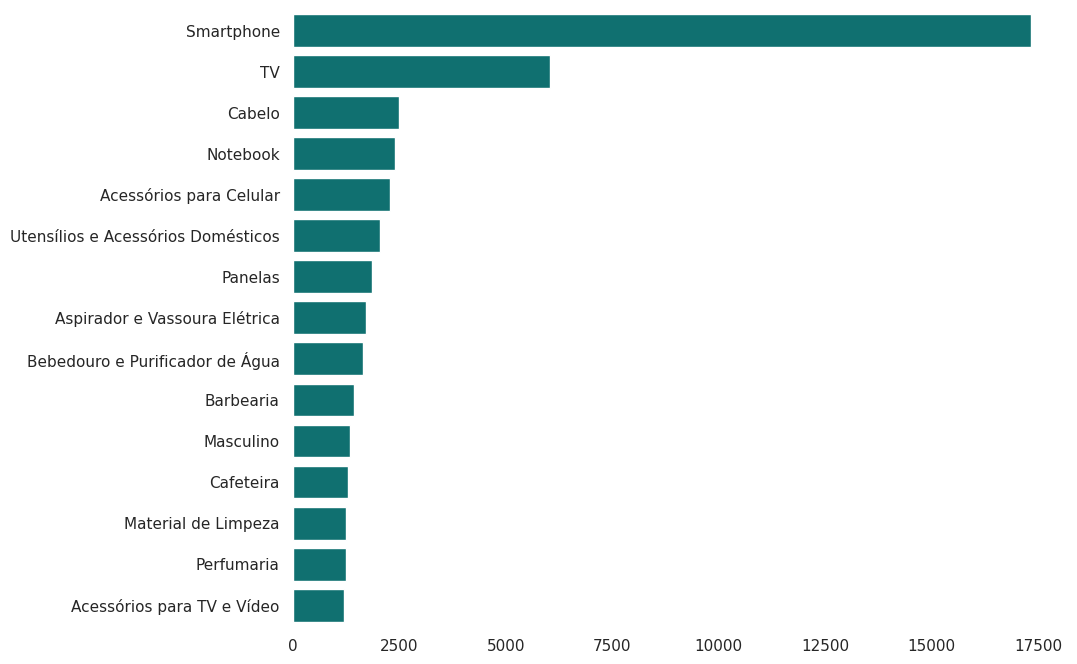

In [ ]:
# Plot das subcategorias mais frequentes
# Contagem
subcategory_count = df['site_category_lv2'].value_counts()

# Seleciona os mais frequentes
top_subcategory = subcategory_count.head(15)

# Cria o gráfico de barras horizontal
sns.set(style='white')
ax = sns.barplot(x=top_subcategory, y=top_subcategory.index, orient='h', color='#008080')
sns.despine(left=True, bottom=True)

# Define os rótulos dos eixos
#ax.set_title('Frequência das subcategorias', fontsize=16)
ax = sns.barplot(x=top_subcategory, y=top_subcategory.index, orient='h', color='#008080')
ax.set(xlabel='', ylabel='')

# Define o tamanho da figura
sns.set(rc={'figure.figsize': (10, 8)})

# Mostra o gráfico
plt.show()

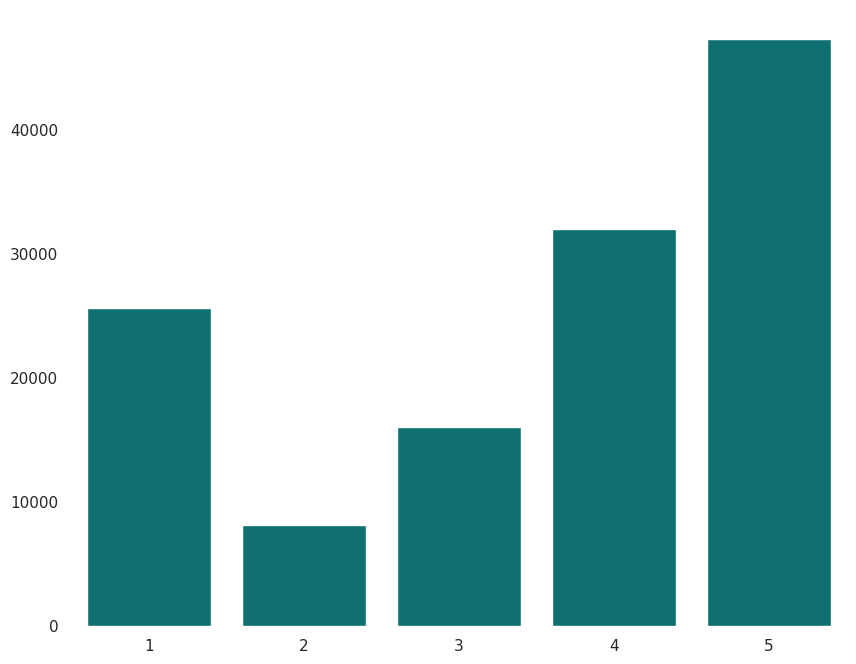

In [ ]:
# Plot das avaliações
# Contagem
rating_count = df['overall_rating'].value_counts()

# Ordenar as classificações por valor
rating_count = rating_count.sort_index()

# Cria o gráfico de barras horizontal
sns.set(style='white')
ax = sns.barplot(x=rating_count.index, y=rating_count, orient='v', color='#008080')
sns.despine(left=True, bottom=True)

# Define os rótulos dos eixos
#ax.set_title('Distribuição das notas de avaliação', fontsize=16)
ax.set(xlabel='', ylabel='')

# Define o tamanho da figura
sns.set(rc={'figure.figsize': (4, 3)})

# Mostra o gráfico
plt.show()

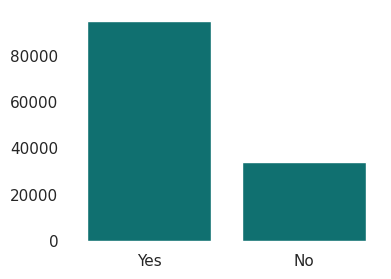

In [ ]:
# Plot das recomendações
# Contagem
rec_count = df['recommend_to_a_friend'].value_counts()

# Cria o gráfico de barras horizontal
sns.set(style='white')
ax = sns.barplot(x=rec_count.index, y=rec_count, orient='v', color='#008080')
sns.despine(left=True, bottom=True)

# Define os rótulos dos eixos
#ax.set_title('Distribuição da recomendação', fontsize=16)
ax.set(xlabel='', ylabel='')

# Define o tamanho da figura
sns.set(rc={'figure.figsize': (4, 3)})

# Mostra o gráfico
plt.show()

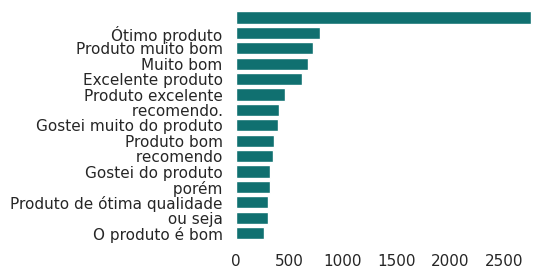

In [ ]:
# Plot das maiores frequências sem tratamento
# Contagem
wordbar_count = df['review_text'].str.split(',', expand=True).stack().value_counts()

# Seleciona os mais frequentes
topf = wordbar_count.nlargest(15)

# Cria o gráfico de barras horizontal
sns.set(style='white')
ax = sns.barplot(x=topf, y=topf.index, orient='h', color='#008080')
sns.despine(left=True, bottom=True)

# Define os rótulos dos eixos
#ax.set_title('Frequência de palavras', fontsize=16)
ax = sns.barplot(x=topf, y=topf.index, orient='h', color='#008080')
#ax.set(xlabel='Frequência', ylabel='Palavras')

# Define o tamanho da figura
sns.set(rc={'figure.figsize': (10, 8)})

# Mostra o gráfico
plt.show()

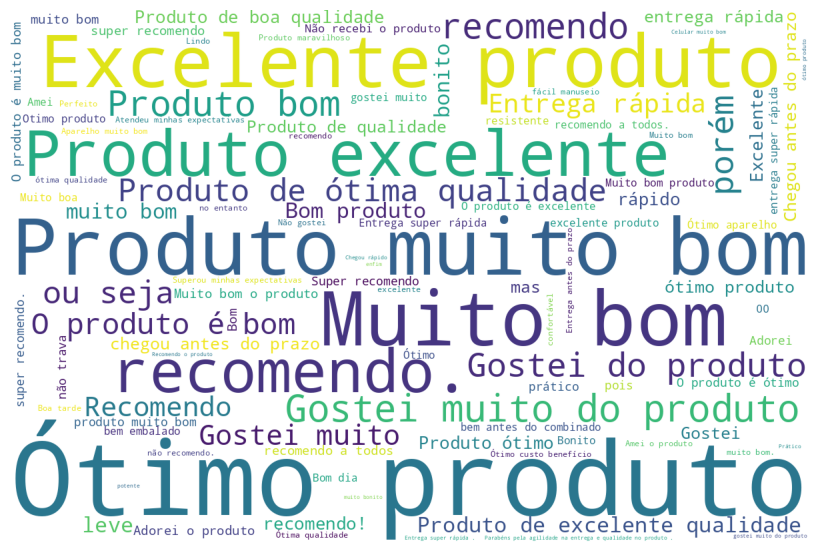

In [ ]:
# Plot Worldcloud sem tratamento
# Contagem
wordcloud_count = df['review_text'].str.split(',', expand=True).stack().value_counts()

# Seleciona os mais frequentes
top_100f = wordcloud_count.nlargest(100)

# Cria a nuvem de palavras
wordcloud = WordCloud(width=1200, height=800, background_color='white').generate_from_frequencies(top_100f)

# Plota a WordCloud
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

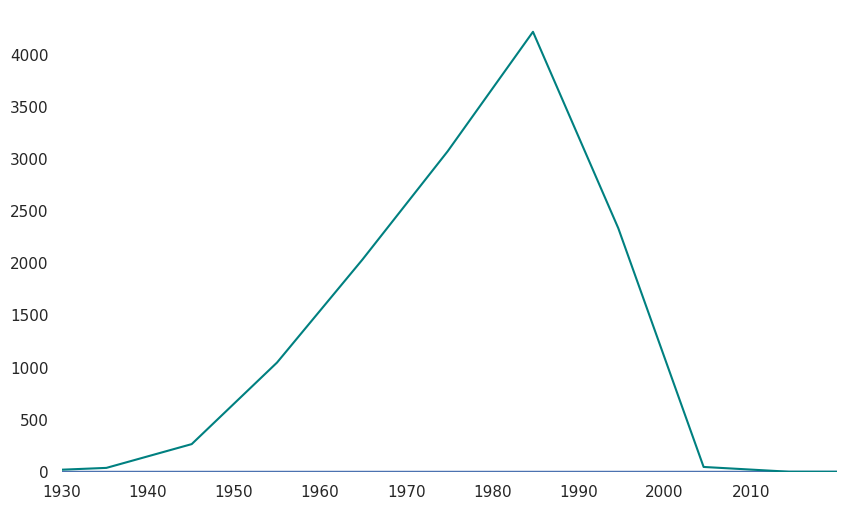

In [ ]:
# Plot do ano de nascimento
# Cria uma figura e os eixos do gráfico
fig, ax = plt.subplots(figsize=(10,6))

# Calcula os valores da densidade
kde_vals = sns.kdeplot(data=df, x='reviewer_birth_year').get_lines()[0].get_data()

# Multiplica os valores da densidade pelo número total de amostras para obter a frequência de vezes
freq_vals = kde_vals[1] * len(df)

# Plota os valores da frequência em um gráfico de linha
ax.plot(kde_vals[0], freq_vals, color='#008080')

# Adiciona um título e rótulos de eixo
#ax.set_title('Distribuição do ano de nascimento', fontsize=16)
ax.set_xlabel('', fontsize=12)
ax.set_ylabel('', fontsize=12)
sns.despine(left=True, bottom=True)

# Define os limites do eixo X
ax.set_xlim(1930, 2020)

# Define os valores dos intervalos do eixo x
ax.set_xticks(range(1930, 2020, 10))

# Gira os rótulos do eixo x em 45 graus para melhorar a legibilidade
#ax.xaxis.set_tick_params(rotation=45)

# Remove a grade de fundo
ax.grid(False)
ax.set_facecolor('none')

# Mostra o gráfico
plt.show()

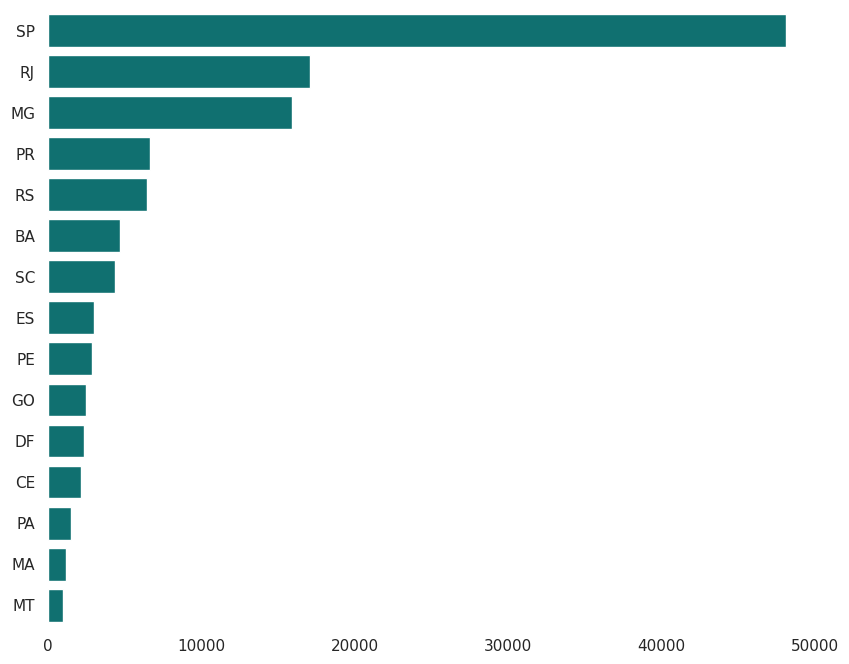

In [ ]:
# Plot dos estados
# Contagem
state_count = df['reviewer_state'].value_counts()

# Seleciona os mais frequentes
top_state = state_count.head(15)

# Cria o gráfico de barras horizontal
sns.set(style='white')
ax = sns.barplot(x=top_state, y=top_state.index, orient='h', color='#008080')
sns.despine(left=True, bottom=True)

# Define os rótulos dos eixos
#ax.set_title('Frequência dos estados', fontsize=16)
ax = sns.barplot(x=top_state, y=top_state.index, orient='h', color='#008080')
ax.set(xlabel='', ylabel='')

# Define o tamanho da figura
sns.set(rc={'figure.figsize': (10, 8)})

# Mostra o gráfico
plt.show()

# Preparação dos dados

In [ ]:
# Os comentários com pontuação de 1 a 2 serão classificados como negativos, o 3 será considerado neutro e removido, e 4 a 5 positivos
#Função
def sentiment_process(df):
    # Criação da nova coluna "sentiment" e preenchendo com valor neutro ('neutro')
    df['sentiment'] = 'neutro'

    # Classificando os comentários com base na pontuação da coluna "overall_rating"
    df.loc[df['overall_rating'] <= 2, 'sentiment'] = 'negative'
    df.loc[df['overall_rating'] >= 4, 'sentiment'] = 'positive'

    # Removendo os comentários com pontuação igual a 3
    df = df[df['overall_rating'] != 3]

    # Criação da nova coluna "sentiment_number" e preenchendo com valor neutro ('neutro')
    df['sentiment_number'] = 'neutro'

    # Classificando os semtimentos com base na pontuação da coluna "sentiment"
    df.loc[df['sentiment'] == 'negative', 'sentiment_number'] = 0
    df.loc[df['sentiment'] == 'positive', 'sentiment_number'] = 1

    # Retornando o DataFrame atualizado
    return df

In [ ]:
# Classes de classificação
class_names = ['negative', 'positive']

In [ ]:
# Chamar a função process_comments passando o DataFrame como argumento
df = sentiment_process(df)

# Exibir o DataFrame processado
display(df.head())

<ipython-input-24-60ad6ada6b8c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_number'] = 'neutro'


,product_name,product_brand,site_category_lv1,site_category_lv2,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_state,original_index,sentiment,sentiment_number
0,Notebook Asus Vivobook Max X541NA-GO472T Intel...,NaN,Informática,Notebook,4,Yes,Estou contente com a compra entrega rápida o ú...,1958.0,RJ,0,positive,1
1,Copo Acrílico Com Canudo 500ml Rocie,NaN,Utilidades Domésticas,"Copos, Taças e Canecas",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996.0,SC,1,positive,1
2,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984.0,SP,2,positive,1
3,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985.0,SP,3,positive,1
4,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",lg,TV e Home Theater,TV,5,Yes,"A entrega foi no prazo, as americanas estão de...",1994.0,MG,4,positive,1


In [ ]:
# Visualização da distribuição de sentimentos
df['sentiment'].value_counts()

positive    79316
negative    33772
Name: sentiment, dtype: int64

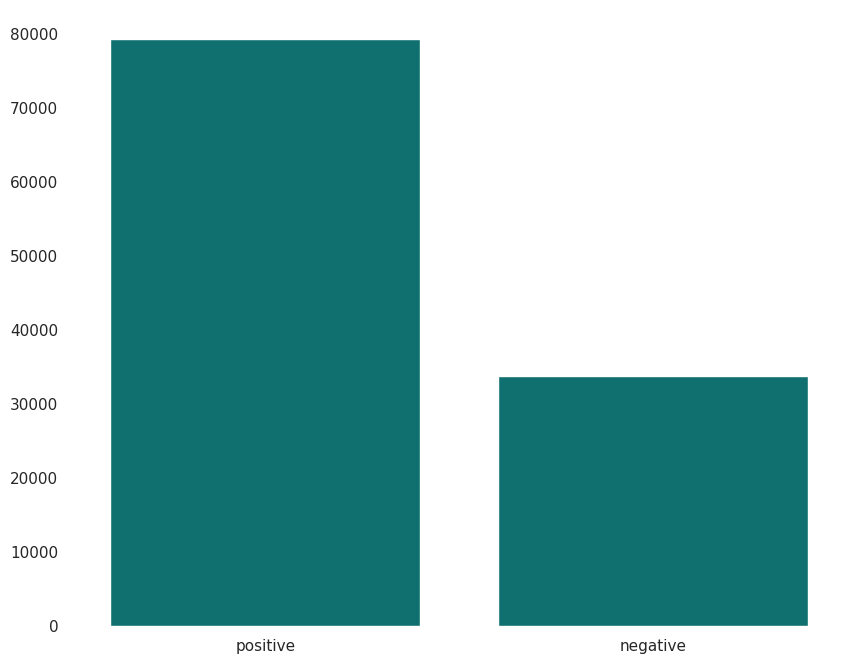

In [ ]:
# Plot dos sentimentos
# Contagem
set_count = df['sentiment'].value_counts()

# Cria o gráfico de barras horizontal
sns.set(style='white')
ax = sns.barplot(x=set_count.index, y=set_count, orient='v', color='#008080')
sns.despine(left=True, bottom=True)

# Define os rótulos dos eixos
#ax.set_title('Distribuição da recomendação', fontsize=16)
ax.set(xlabel='', ylabel='')

# Define o tamanho da figura
sns.set(rc={'figure.figsize': (4, 3)})

# Mostra o gráfico
plt.show()

# EDA Sentimento Negativo

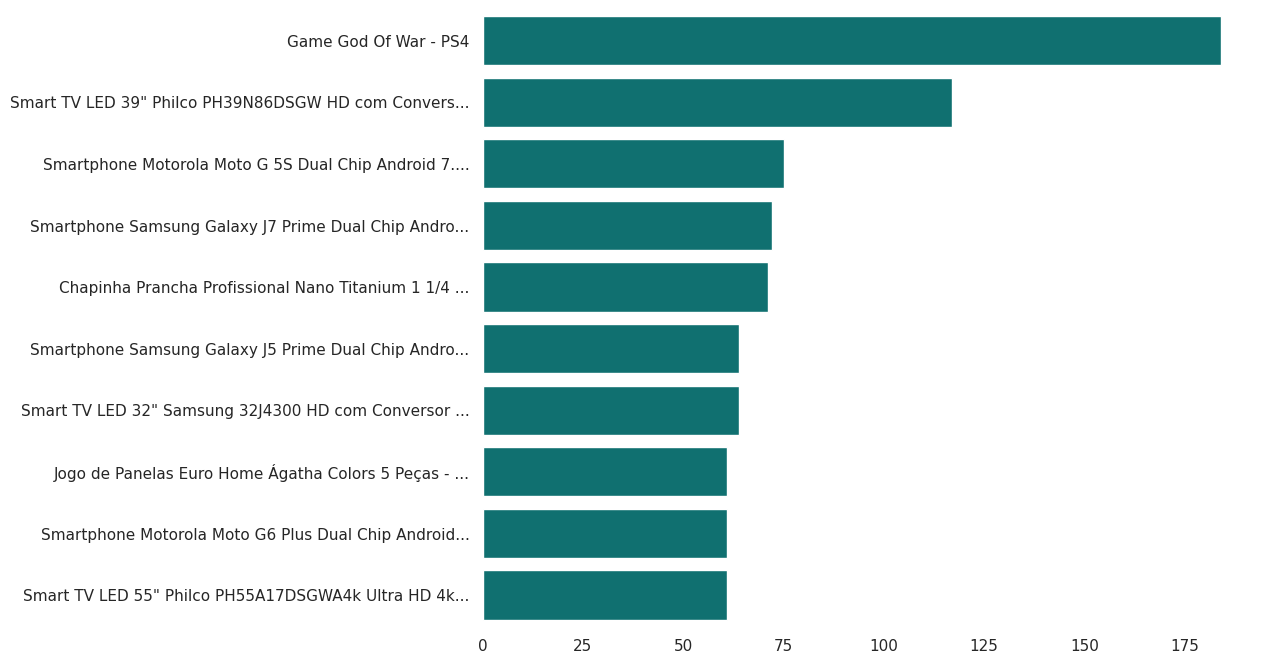

In [ ]:
# Plot dos produtos mais frequentes negativos
# Contagem
product_count_neg = df[df['sentiment'] == 'negative']['product_name'].value_counts()

# Seleciona os mais frequentes
top_products_neg = product_count_neg.head(10)

# Limita o número de letras dos nomes dos produtos
top_products_neg.index = [name[:50] + '...' if len(name) > 50 else name for name in top_products_neg.index]

# Cria o gráfico de barras horizontal
sns.set(style='white')
ax = sns.barplot(x=top_products_neg, y=top_products_neg.index, orient='h', color='#008080')
sns.despine(left=True, bottom=True)

# Define os rótulos dos eixos
# ax.set_title('Frequência dos produtos', fontsize=16)
ax.set(xlabel='', ylabel='')

# Define o tamanho da figura
sns.set(rc={'figure.figsize': (10, 8)})

# Mostra o gráfico
plt.show()


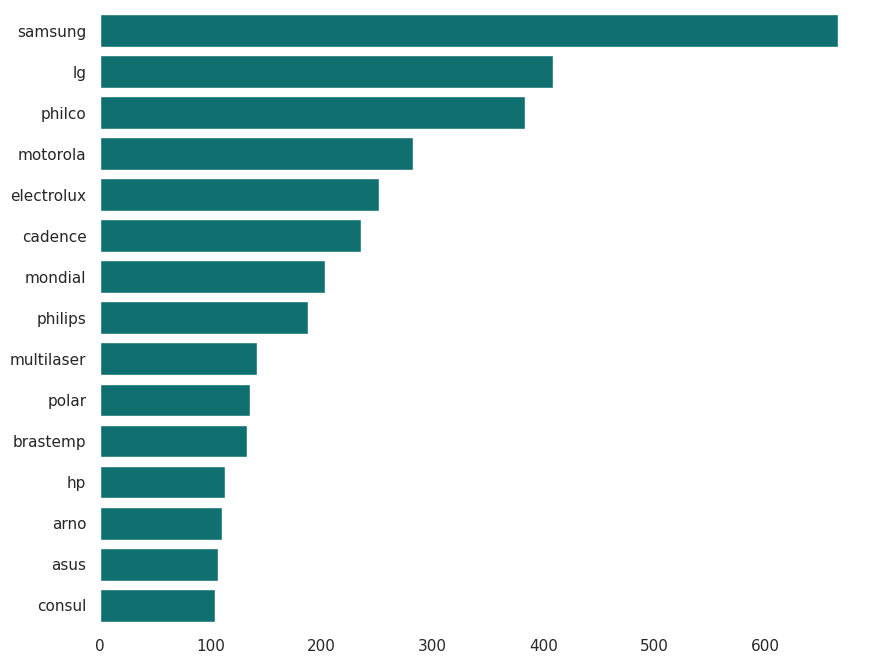

In [ ]:
# Plot das marcas mais frequentes negativo
# Contagem
brand_count_neg = df[df['sentiment'] == 'negative']['product_brand'].value_counts()

# Seleciona os mais frequentes
top_brand_neg = brand_count_neg.head(15)

# Cria o gráfico de barras horizontal
sns.set(style='white')
ax = sns.barplot(x=top_brand_neg, y=top_brand_neg.index, orient='h', color='#008080')
sns.despine(left=True, bottom=True)

# Define os rótulos dos eixos
#ax.set_title('Frequência das marcas', fontsize=16)
ax = sns.barplot(x=top_brand_neg, y=top_brand_neg.index, orient='h', color='#008080')
ax.set(xlabel='', ylabel='')

# Define o tamanho da figura
sns.set(rc={'figure.figsize': (10, 8)})

# Mostra o gráfico
plt.show()

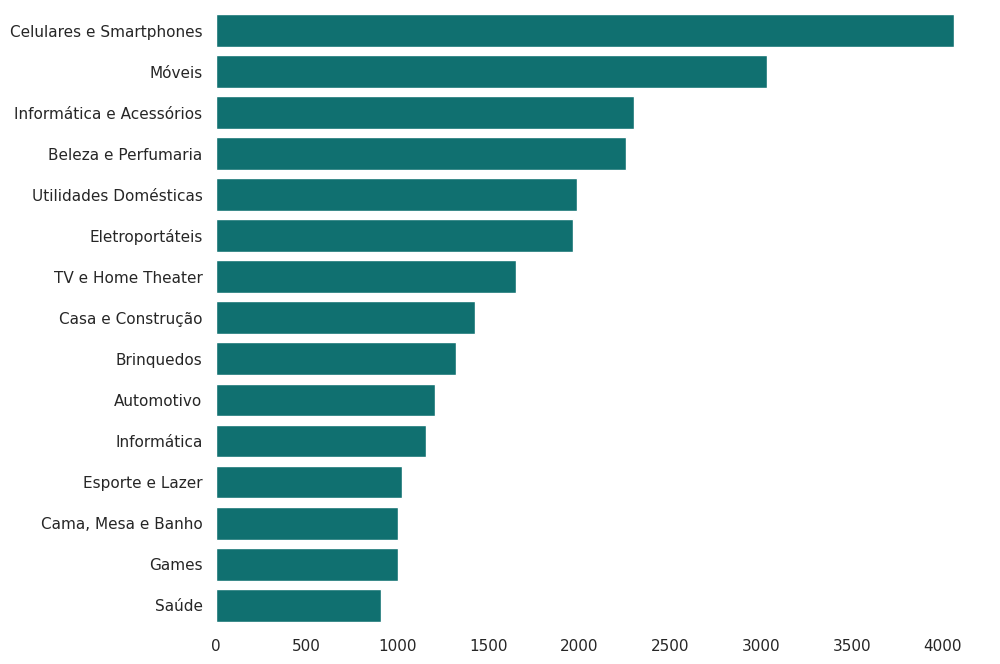

In [ ]:
# Plot das categorias mais frequentes negativo
# Contagem
category_count_neg = df[df['sentiment'] == 'negative']['site_category_lv1'].value_counts()

# Seleciona os mais frequentes
top_category_neg = category_count_neg.head(15)

# Cria o gráfico de barras horizontal
sns.set(style='white')
ax = sns.barplot(x=top_category_neg, y=top_category_neg.index, orient='h', color='#008080')
sns.despine(left=True, bottom=True)

# Define os rótulos dos eixos
#ax.set_title('Frequência das categorias', fontsize=16)
ax = sns.barplot(x=top_category_neg, y=top_category_neg.index, orient='h', color='#008080')
ax.set(xlabel='', ylabel='')

# Define o tamanho da figura
sns.set(rc={'figure.figsize': (10, 8)})

# Mostra o gráfico
plt.show()

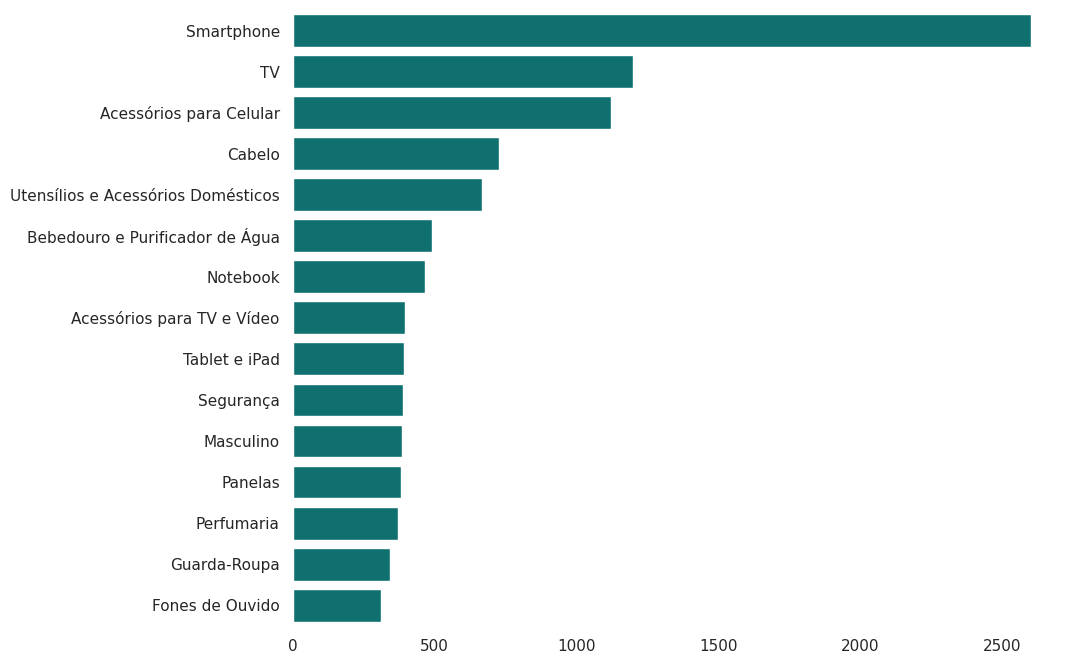

In [ ]:
# Plot das subcategorias mais frequentes negativo
# Contagem
subcategory_count_neg = df[df['sentiment'] == 'negative']['site_category_lv2'].value_counts()

# Seleciona os mais frequentes
top_subcategory_neg = subcategory_count_neg.head(15)

# Cria o gráfico de barras horizontal
sns.set(style='white')
ax = sns.barplot(x=top_subcategory_neg, y=top_subcategory_neg.index, orient='h', color='#008080')
sns.despine(left=True, bottom=True)

# Define os rótulos dos eixos
#ax.set_title('Frequência das subcategorias', fontsize=16)
ax = sns.barplot(x=top_subcategory_neg, y=top_subcategory_neg.index, orient='h', color='#008080')
ax.set(xlabel='', ylabel='')

# Define o tamanho da figura
sns.set(rc={'figure.figsize': (10, 8)})

# Mostra o gráfico
plt.show()

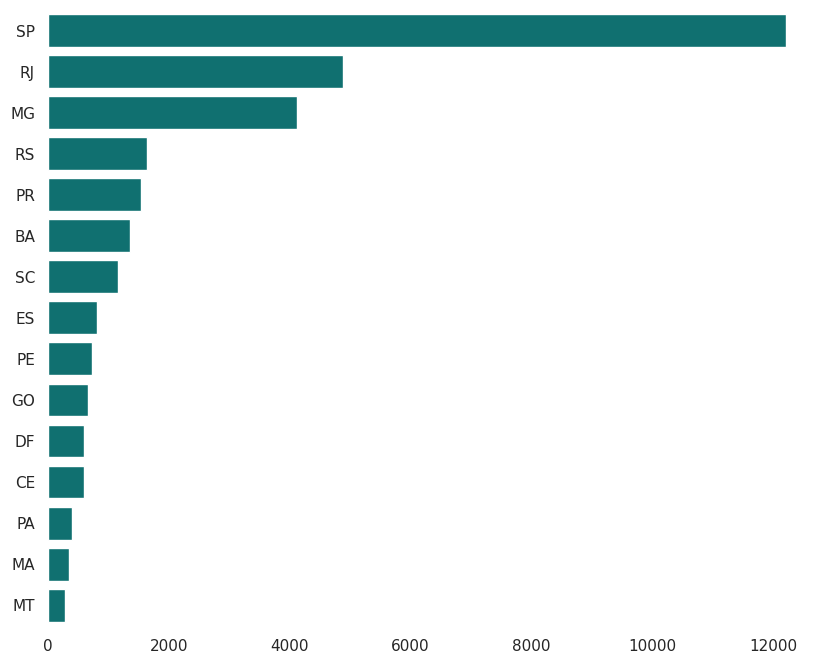

In [ ]:
# Plot dos estados negativo
# Contagem
state_count_neg = df[df['sentiment'] == 'negative']['reviewer_state'].value_counts()

# Seleciona os mais frequentes
top_state_neg = state_count_neg.head(15)

# Cria o gráfico de barras horizontal
sns.set(style='white')
ax = sns.barplot(x=top_state_neg, y=top_state_neg.index, orient='h', color='#008080')
sns.despine(left=True, bottom=True)

# Define os rótulos dos eixos
#ax.set_title('Frequência dos estados', fontsize=16)
ax = sns.barplot(x=top_state_neg, y=top_state_neg.index, orient='h', color='#008080')
ax.set(xlabel='', ylabel='')

# Define o tamanho da figura
sns.set(rc={'figure.figsize': (10, 8)})

# Mostra o gráfico
plt.show()

# Processamento

In [ ]:
# Seleção do modelo
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'

In [ ]:
# Tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
# Testando a tokenização
sample_txt = 'Estou trabalhando no meu primeiro projeto com grande modelo de linguagem.'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Estou trabalhando no meu primeiro projeto com grande modelo de linguagem.
   Tokens: ['Est', '##ou', 'trabalhando', 'no', 'meu', 'primeiro', 'projeto', 'com', 'grande', 'modelo', 'de', 'linguagem', '.']
Token IDs: [9009, 203, 6564, 202, 7343, 652, 1778, 170, 739, 2519, 125, 4616, 119]


In [ ]:
# Tokens especiais
# [SEP] - marcador para o final de uma frase
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [ ]:
# [CLS] - marcador para o início de uma frase
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [ ]:
# [PAD] - marcador para padding
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [ ]:
# [UNK] - marcador para desconhecido
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [ ]:
# Encoding
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt',  # Retorna PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
# Verificação dos tokens id, armazenados em um Tensor com comprimento de 32
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 9009,  203, 6564,  202, 7343,  652, 1778,  170,  739, 2519,  125,
        4616,  119,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:
# Verificação das masks
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
# Verificação tokens especiais
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'Est',
 '##ou',
 'trabalhando',
 'no',
 'meu',
 'primeiro',
 'projeto',
 'com',
 'grande',
 'modelo',
 'de',
 'linguagem',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

# Configuração do comprimento das sequências

In [ ]:
# Verificação dos comprimentos dos comentários para definição no BERT
token_lens = []

for txt in df.review_text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


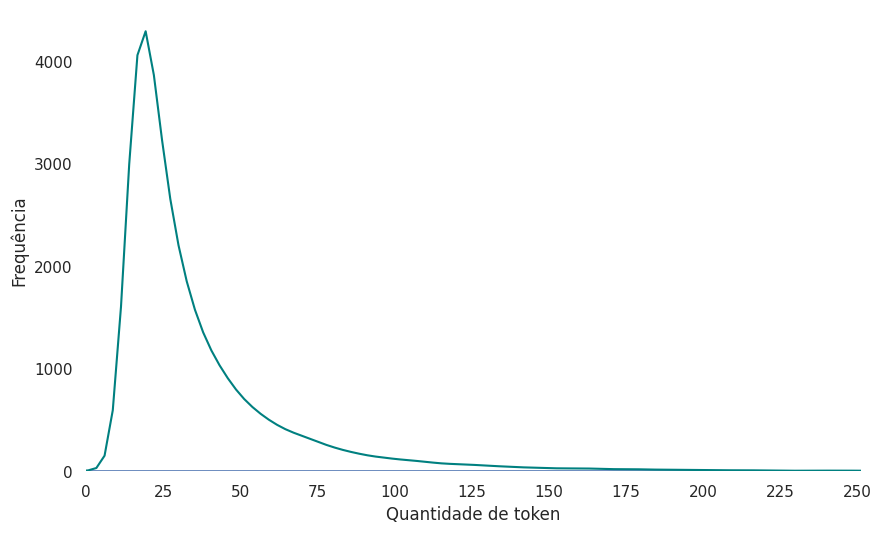

In [ ]:
# Plot dos comprimentos dos comentários para definição no BERT
# Cria uma figura e os eixos do gráfico
fig, ax = plt.subplots(figsize=(10,6))

# Calcula os valores da densidade
kde_vals = sns.kdeplot(data=token_lens).get_lines()[0].get_data()

# Multiplica os valores da densidade pelo número total de amostras para obter a frequência de vezes
freq_vals = kde_vals[1] * len(token_lens)

# Plota os valores da frequência em um gráfico de linha
ax.plot(kde_vals[0], freq_vals, color='#008080')

# Adiciona um título e rótulos de eixo
# ax.set_title('Distribuição dos comprimentos dos comentários', fontsize=16)
ax.set_xlabel('Quantidade de token', fontsize=12)
ax.set_ylabel('Frequência', fontsize=12)
sns.despine(left=True, bottom=True)

# Define os limites do eixo X
ax.set_xlim(0, 251)

# Define os valores dos intervalos do eixo x
ax.set_xticks(range(0, 251, 25))

# Remove a grade de fundo
ax.grid(False)
ax.set_facecolor('none')

# Mostra o gráfico
plt.show()

In [ ]:
# Verifica-se que a maioria dos comentários contém menos de 130 tokens, portanto será utilizado o comprimento máximo de 160
# Caso necessário alterar, procurar por MAX_LEN no início do notebook

In [ ]:
# Criação do dataset PyTorch
class ReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
# Divisão do dataset para treino, teste e validação
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
# Verificação da divisão
df_train.shape, df_val.shape, df_test.shape

((101779, 12), (5654, 12), (5655, 12))

In [ ]:
# Data loaders
# Função
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ReviewDataset(
    reviews = df.review_text.to_numpy(),
    targets = df.sentiment_number.to_numpy(),
    tokenizer = tokenizer,
    max_len = max_len,
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
# Caso necessário alterar, procurar por BATCH_SIZE no início do notebook

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Verificação amostra
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
# Print amostra
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


# Classificação de sentimento com BERT e Hugging Face

In [ ]:
# Carregar modelo BERT
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Encoding o teste sample_txt
last_hidden_state, pooled_output = bert_model(
    input_ids=encoding['input_ids'],
    attention_mask=encoding['attention_mask'],
    return_dict = False
)

In [ ]:
# Retorna o formato (shape) do tensor 'last_hidden_state'
last_hidden_state.shape

torch.Size([1, 32, 768])

In [ ]:
# Acessa o tamanho do vetor de representação oculta do modelo BERT
bert_model.config.hidden_size

768

In [ ]:
# Retorna o formato (shape) do tensor 'pooled_output'
pooled_output.shape

torch.Size([1, 768])

In [ ]:
# Classificador de sentimentos com BERT

class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict = False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
# Processamento com o BERT com regularização das camadas e troca para GPU
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Troca para GPU
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [ ]:
# Aplicação da função softmax às saídas para obter as probabilidades previstas do modelo treinado
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5467, 0.4533],
        [0.5652, 0.4348],
        [0.5325, 0.4675],
        [0.5722, 0.4278],
        [0.6558, 0.3442],
        [0.5285, 0.4715],
        [0.5124, 0.4876],
        [0.6422, 0.3578],
        [0.6225, 0.3775],
        [0.5937, 0.4063],
        [0.5488, 0.4512],
        [0.5767, 0.4233],
        [0.5841, 0.4159],
        [0.5841, 0.4159],
        [0.7363, 0.2637],
        [0.5794, 0.4206]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

# Treino

In [ ]:
# Otimizador AdamW para correção da queda de peso e agendador linear sem etapas de aquecimento
# Caso necessário alterar, procurar por EPOCHS e LR no início do notebook

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
# Função auxiliar para treinar o modelo
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# Função auxiliar para treinar o modelo
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/3
----------
Train loss 0.12330031066793365 accuracy 0.9616718576523644
Val   loss 0.09235705527224404 accuracy 0.9709939865581889

Epoch 2/3
----------
Train loss 0.07409968642916998 accuracy 0.9804478330500397
Val   loss 0.11550309873535626 accuracy 0.9708171206225681

Epoch 3/3
----------
Train loss 0.04559898767823073 accuracy 0.9895165014393932
Val   loss 0.15066711788919443 accuracy 0.9697559250088433

CPU times: user 2h 11min 20s, sys: 34.6 s, total: 2h 11min 54s
Wall time: 2h 14min 2s


In [ ]:
# Move tensores para CPU
train_acc_cpu = [acc.item() for acc in history['train_acc']]
val_acc_cpu = [acc.item() for acc in history['val_acc']]

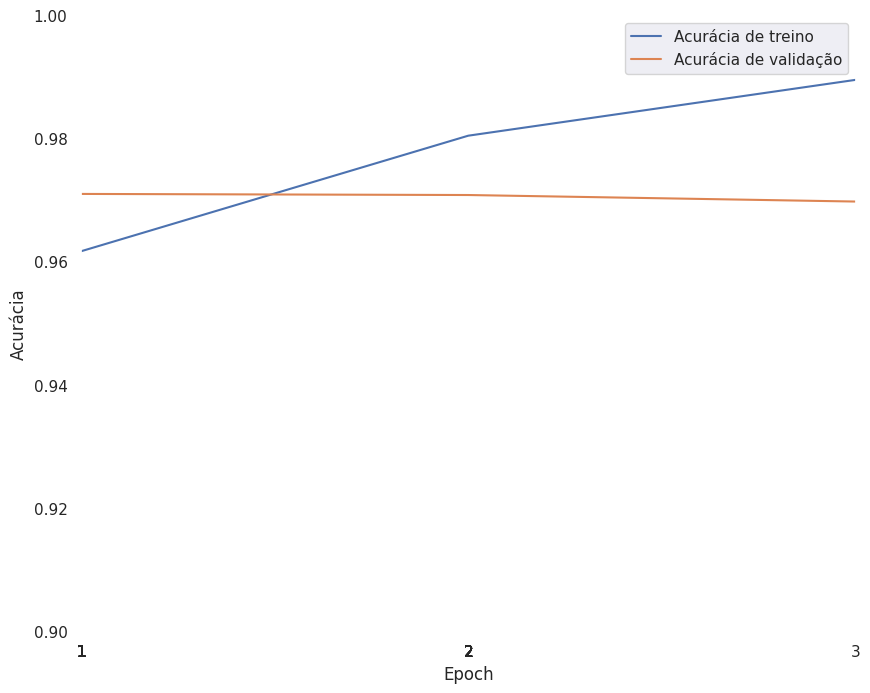

In [ ]:
# Plot treino x validação
plt.plot(range(1, EPOCHS+1), train_acc_cpu, label='Acurácia de treino')
plt.plot(range(1, EPOCHS+1), val_acc_cpu, label='Acurácia de validação')

#plt.title('Histórico de treino')
plt.ylabel('Acurácia')
plt.xlabel('Epoch')
plt.ylim(0.9, 1)
plt.xlim(1, EPOCHS)
plt.legend()
plt.xticks(np.linspace(1, EPOCHS, dtype=int))

# Alterar a cor do fundo para branco
plt.gca().set_facecolor('white')

# Desativar as grades de fundo
plt.grid(False)

plt.show()

# Avaliação

In [ ]:
# Cálculo da acurácia
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9738284703801945

In [ ]:
# Função auxiliar para predição
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
# Semelhante à função de avaliação, mas armazena o texto das revisões e as probabilidades previstas com softmax
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
# Print do report da classificação
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.96      0.95      0.96      1668
    positive       0.98      0.98      0.98      3987

    accuracy                           0.97      5655
   macro avg       0.97      0.97      0.97      5655
weighted avg       0.97      0.97      0.97      5655



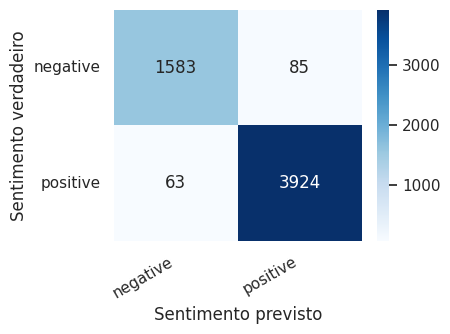

In [ ]:
# Matriz de confusão
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('Sentimento verdadeiro')
  plt.xlabel('Sentimento previsto');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
# Exemplos de predição
idx = 67

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
# Print
print("\n".join(wrap(review_text)))
print()
print(f'Sentimento: {class_names[true_sentiment]}')

Estava querendo comprar esse notebook a tempos. Cumpre com o que
promete.

Sentimento: negative


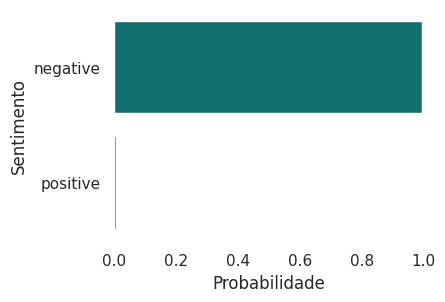

In [ ]:
# Print confiança do modelo
sns.barplot(x='values', y='class_names', data=pred_df, orient='h', color='#008080')
plt.ylabel('Sentimento')
plt.xlabel('Probabilidade')
plt.xlim([0, 1])

# Alterar a cor do fundo para branco
plt.gca().set_facecolor('white')

# Desativar as grades de fundo
plt.grid(False)

# Exibir o gráfico
plt.show()

# Prevendo em texto bruto

In [ ]:
# Texto bruto
review_text = "Estava querendo comprar esse notebook a tempos. Cumpre com o que promete."

In [ ]:
# Tokenizer
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
# Predição
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: Estava querendo comprar esse notebook a tempos. Cumpre com o que promete.
Sentiment  : positive


# Fim